In [1]:
import fxcmpy
api = fxcmpy.fxcmpy(access_token='83eaf60d3c3c50e51a518aa92eb9a2047b093ace', log_level='error')

In [2]:
data = api.get_candles('EUR/USD', period='m5', start='2018-06-01 00:00:00', stop='2018-06-30 00:00:00')

In [4]:
data.iloc[-5:,4:]

,askopen,askclose,askhigh,asklow,tickqty
date,,,,,
2018-06-29 20:35:00,1.16865,1.16885,1.16899,1.16842,601
2018-06-29 20:40:00,1.16885,1.16856,1.16901,1.16855,387
2018-06-29 20:45:00,1.16856,1.16829,1.16865,1.16825,592
2018-06-29 20:50:00,1.16829,1.16839,1.16849,1.16822,842
2018-06-29 20:55:00,1.16839,1.16864,1.16879,1.16837,540


In [5]:
spread = (data['askclose'] - data['bidclose']).mean()

In [6]:
spread

9.633897747821927e-05

In [7]:
data['midclose'] = (data['askclose'] + data['bidclose'])/2

In [8]:
ptc = spread/data['midclose'].mean()

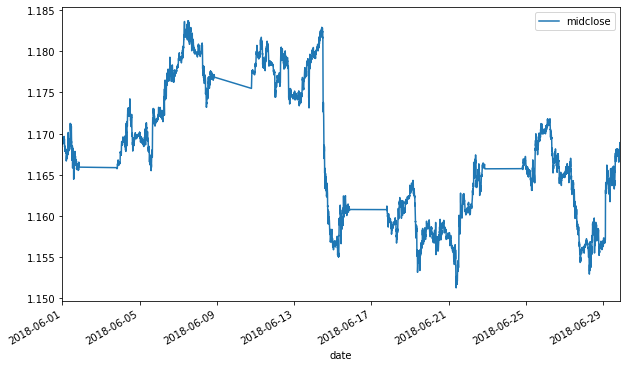

In [12]:
data['midclose'].plot(figsize=(10,6), legend=True)

date
2018-06-01 00:00:00    1.168995
2018-06-01 00:05:00    1.169030
2018-06-01 00:10:00    1.168735
2018-06-01 00:15:00    1.168785
2018-06-01 00:20:00    1.168680
2018-06-01 00:25:00    1.168685
2018-06-01 00:30:00    1.168885
2018-06-01 00:35:00    1.168985
2018-06-01 00:40:00    1.169080
2018-06-01 00:45:00    1.169200
2018-06-01 00:50:00    1.169115
2018-06-01 00:55:00    1.169400
2018-06-01 01:00:00    1.169395
2018-06-01 01:05:00    1.169440
2018-06-01 01:10:00    1.169550
2018-06-01 01:15:00    1.168890
2018-06-01 01:20:00    1.168845
2018-06-01 01:25:00    1.169045
2018-06-01 01:30:00    1.169050
2018-06-01 01:35:00    1.169595
2018-06-01 01:40:00    1.169425
2018-06-01 01:45:00    1.169285
2018-06-01 01:50:00    1.169575
2018-06-01 01:55:00    1.169120
2018-06-01 02:00:00    1.169240
2018-06-01 02:05:00    1.169150
2018-06-01 02:10:00    1.169150
2018-06-01 02:15:00    1.169450
2018-06-01 02:20:00    1.169445
2018-06-01 02:25:00    1.169440
                         ...   
201

In [14]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [15]:
data['returns'] = np.log(data['midclose']/ data['midclose'
                                               ].shift(1))


In [17]:
data.dropna(inplace=True)
lags = 5
cols = []
for lag in range(1,lags+1):
    col = 'lag_{}'.format(lag)
    data[col] = data['returns'].shift(lag)
    cols.append(col)

In [18]:
data[cols] = np.where(data[cols] > 0, 1, 0)

In [19]:
data['direction'] = np.where(data['returns'] > 0, 1,-1)

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [22]:
model = SVC(C=1, kernel='linear', gamma='auto')
split = int(len(data) * 0.80)
train = data.iloc[:split].copy()
model.fit(train[cols], train['direction'])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
accuracy_score(train['direction'], model.predict(train[cols]))

0.5204522096608427

In [25]:
test = data.iloc[split:].copy()

In [26]:
test['position'] = model.predict(test[cols])
accuracy_score(test['direction'], test['position'])

0.543138866064092

In [27]:
test['strategy'] = test['position'] * test['returns']
sum(test['position'].diff() != 0)

662

In [29]:
test['strategy_tc'] = np.where(test['position'].diff() != 0, test['strategy'] - ptc, test['strategy'])

In [30]:
sel = ['tradeId', 'amountK', 'currency', 'grossPL', 'isBuy']
def print_positions(pos):
    print('\n\n' + 50 * '=')
    print('Going {}.\n'.format(pos))
    time.sleep(1.5)
    print(api.get_open_positions()[sel])
    print(50 * '=' + '\n\n')

In [31]:
symbol = 'EUR/USD'
bar = '15s'
amount = 100
position = 0
min_bars = lags + 1
df = pd.DataFrame()

In [34]:
import pickle

In [35]:
pickle.dump(model, open('algorithm.pkl', 'wb'))

In [37]:
def automated_strategy(data, dataframe):
    ''' Callback function embodying the trading logic.
    '''
    global min_bars, position, df
    # resampling of the tick data
    df = dataframe.resample(bar, label='right').last().ffill()

    if len(df) > min_bars:
        min_bars = len(df)
        logger_monitor('NUMBER OF BARS: ' + str(min_bars))
        # data processing and feature preparation
        df['Mid'] = df[['Bid', 'Ask']].mean(axis=1)
        df['Returns'] = np.log(df['Mid'] / df['Mid'].shift(1))
        df['Direction'] = np.where(df['Returns'] > 0, 1, -1)
        # picks relevant points
        features = df['Direction'].iloc[-(lags + 1):-1]
        # necessary reshaping
        features = features.values.reshape(1, -1)
        # generates the signal (+1 or -1)
        signal = algorithm.predict(features)[0]

        # logs and sends major financial information
        logger_monitor('MOST RECENT DATA\n' +
                       str(df[['Mid', 'Returns', 'Direction']].tail()),
                       False)
        logger_monitor('features: ' + str(features) + '\n' +
                       'position: ' + str(position) + '\n' +
                       'signal:   ' + str(signal), False)

        # trading logic
        if position in [0, -1] and signal == 1:  # going long?
            api.create_market_buy_order(
                symbol, size - position * size)  # places a buy order
            position = 1  # changes position to long
            report_positions('LONG')

        elif position in [0, 1] and signal == -1:  # going short?
            api.create_market_sell_order(
                symbol, size + position * size)  # places a sell order
            position = -1  # changes position to short
            report_positions('SHORT')
        else:  # no trade
            logger_monitor('no trade placed')

        logger_monitor('****END OF CYCLE***\n\n', False, False)

    if len(dataframe) > 350:  # stopping condition
        api.unsubscribe_market_data('EUR/USD')  # unsubscribes from data stream
        report_positions('CLOSE OUT')
        api.close_all()  # closes all open positions
        logger_monitor('***CLOSING OUT ALL POSITIONS***')


In [ ]:
if __name__ == '__main__':
    symbol = 'EUR/USD'  # symbol to be traded
    bar = '15s'  # bar length; adjust for testing and deployment
    size = 100  # position size in thousand currency units
    position = 0  # initial position
    lags = 5  # number of lags for features data
    min_bars = lags + 1  # minimum length for resampled DataFrame
    df = pd.DataFrame()
    # adjust configuration file location
    api = fxcmpy.fxcmpy(access_token='83eaf60d3c3c50e51a518aa92eb9a2047b093ace', log_level='error')
    # the main asynchronous loop using the callback function
    api.subscribe_market_data(symbol, (automated_strategy,))

In [ ]:
import zmq

# sets up the socket communication via ZeroMQ (here: "subscriber")
context = zmq.Context()
socket = context.socket(zmq.SUB)

# adjust the IP address to reflect the remote location if necessary
socket.connect('tcp://0.0.0.0:5555')

# configures the socket to retrieve every message
socket.setsockopt_string(zmq.SUBSCRIBE, '')

while True:
    msg = socket.recv_string()
    print(msg)